### 1. Import and data loading

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,ECOID
0,2504,2371,1.0,0,133,2437.5,1,0
1,2487,2596,0.5,0,109,2541.5,0,0
2,2915,2921,0.5,0,6,2918.0,0,0
3,2542,2433,1.0,0,109,2487.5,1,10
4,2473,2658,0.0,0,185,2565.5,0,0


### 2. Prepare data

In [3]:
X = df.drop("ResultNumeric", axis=1)
y = df["ResultNumeric"]

# 0 = Black Win, 1 = Draw, 2 = White Win
y = y.map({0.0: 0, 0.5: 1, 1.0: 2})

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

feature_names = X.columns

Features: (3268698, 7)
Target: (3268698,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y,
)

#### Scale Feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32), max_iter=200, random_state=42, early_stopping=True
)

In [7]:
start_time = time.time()

mlp_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(
    f"Training completed in {training_time:.2f} seconds ({training_time / 60:.2f} minutes)"
)

Training completed in 71.86 seconds (1.20 minutes)


### 5. Evaluate

In [8]:
y_pred = mlp_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)\n")

print("Classification Report: \n")
print(
    classification_report(
        y_test, y_pred, target_names=["Black Win", "Draw", "White Win"]
    )
)

Accuracy: 0.5824 (58.24%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.55      0.57      0.56    267788
        Draw       0.87      0.26      0.40     84331
   White Win       0.58      0.68      0.63    301621

    accuracy                           0.58    653740
   macro avg       0.67      0.51      0.53    653740
weighted avg       0.61      0.58      0.57    653740



### 6. Confusion Matrix

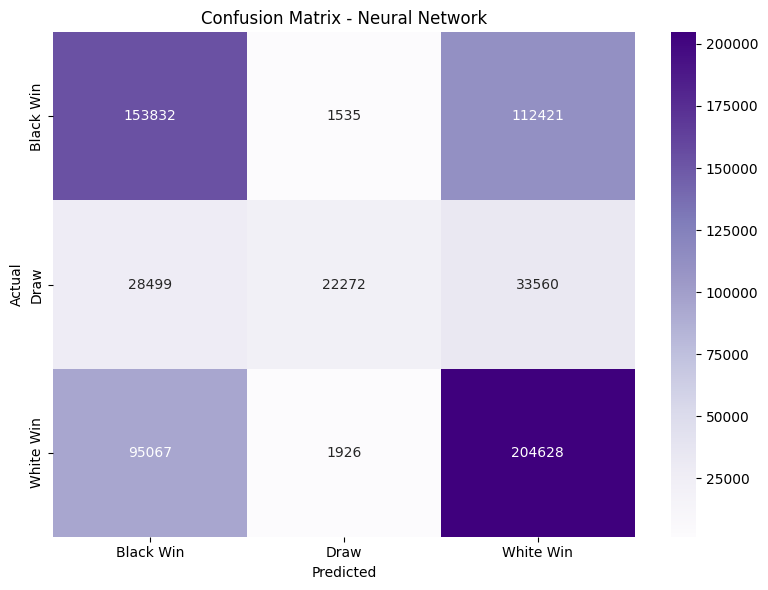

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Black Win", "Draw", "White Win"],
    yticklabels=["Black Win", "Draw", "White Win"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Neural Network")
plt.tight_layout()
plt.show()

### 7. Permutation Feature Importance

In [10]:
result = permutation_importance(
    mlp_model,
    X_test_scaled,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
)

In [11]:
importances_mean = result.importances_mean
importances_std = result.importances_std

In [12]:
importance_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance": importances_mean,
        "Std": importances_std,
    }
).sort_values("Importance", ascending=False)

print("Permutation Feature Importance - Neural Network:")
print(importance_df)

Permutation Feature Importance - Neural Network:
              Feature  Importance       Std
5  WhiteIsHigherRated    0.062439  0.000692
0            WhiteElo    0.041085  0.000476
1            BlackElo    0.039124  0.000242
4           AvgRating    0.008225  0.000181
3          RatingDiff    0.005383  0.000178
2         EventTypeID    0.002844  0.000038
6               ECOID    0.000207  0.000098


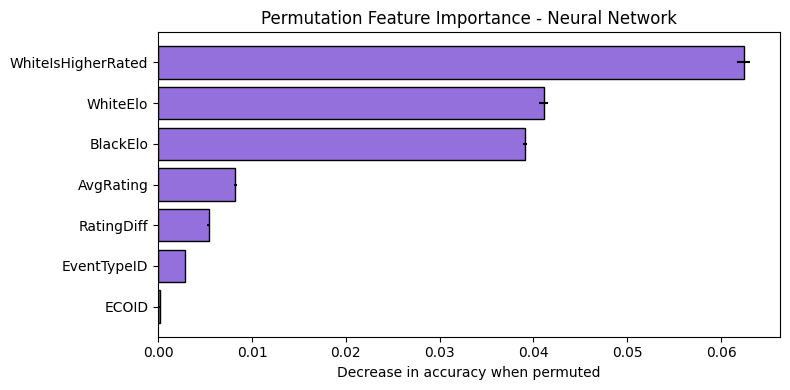

In [13]:
plt.figure(figsize=(8, 4))
plt.barh(
    importance_df["Feature"][::-1],
    importance_df["Importance"][::-1],
    xerr=importance_df["Std"][::-1],
    color="mediumpurple",
    edgecolor="black",
)
plt.xlabel("Decrease in accuracy when permuted")
plt.title("Permutation Feature Importance - Neural Network")
plt.tight_layout()
plt.show()